### **Read data**

In [13]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

data_root = './dataset'
data_path = os.path.join(data_root, 'churn_data_clean.csv')

df = pd.read_csv(data_path)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,0,1,0,1,0,0,0,0,1,0


In [14]:
df.shape

(10348, 27)

### **Split Data**
Split data into training, validation, testing set with ratio 7:1:2

In [15]:
X = df.loc[:, df.columns != 'Churn'] # Features
y = df.loc[:, df.columns == 'Churn'] # Target
print(X.shape)
print(y.shape)

(10348, 26)
(10348, 1)


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1)

print('Training set: ', y_train.shape)
print('Validation set: ', y_val.shape)
print('Testing set: ', y_test.shape)

Training set:  (7243, 1)
Validation set:  (1035, 1)
Testing set:  (2070, 1)


### **Normalization**

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)

### **Bagging SVM**

In [18]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

svm_classifier = SVC(gamma='auto')

bagging_classifier = BaggingClassifier(base_estimator=svm_classifier, n_estimators=10, random_state=42)

# Measure the training time of the model
t0 = time.time()

bagging_classifier = bagging_classifier.fit(X_train, y_train.values.ravel())

bagging_train_time = time.time()-t0
print(f'Training time: {bagging_train_time:.2f} s')

c:\Users\xiaoc\anaconda3\envs\keras\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training time: 27.30 s


Accuracy: 0.8029
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       493
           1       0.85      0.76      0.80       542

    accuracy                           0.80      1035
   macro avg       0.81      0.81      0.80      1035
weighted avg       0.81      0.80      0.80      1035



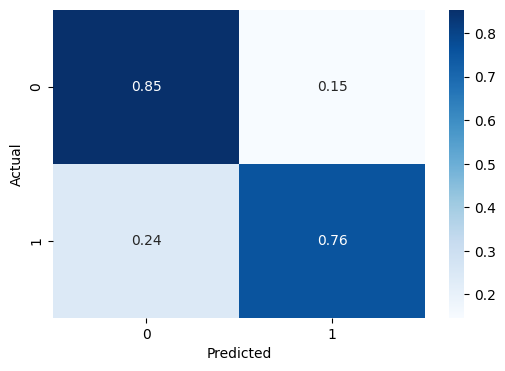

In [38]:
y_val_bagging_pred = bagging_classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_val_bagging_pred)

print(f'Accuracy: {accuracy:.4f}')

print('Classification Report:')
print(classification_report(y_val, y_val_bagging_pred))
bagging_confmat = confusion_matrix(y_val, y_val_bagging_pred, normalize='true')

plt.figure(figsize=(6,4))
sns.heatmap(bagging_confmat,annot=True,cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Hyper-parameters Tuning for SVM

In [40]:
from sklearn.model_selection import GridSearchCV

# param_grid = {'C': [0.1,1,10,100], 'gamma': ['auto'], 'kernel': ['rbf', 'poly', 'sigmoid']}
# svm_grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)

param_grid = {'C' : [0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
svm_grid = GridSearchCV(estimator=SVC(), param_grid=param_grid, scoring='accuracy', verbose=3)
svm_grid.fit(X_train,y_train.values.ravel())

# print best parameter after tuning 
print(svm_grid.best_params_) 
# print best model after hyper-parameter tuning 
print(svm_grid.best_estimator_) 

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ...............C=0.1, gamma=0.0001;, score=0.683 total time=   2.3s
[CV 2/5] END ...............C=0.1, gamma=0.0001;, score=0.684 total time=   3.1s
[CV 3/5] END ...............C=0.1, gamma=0.0001;, score=0.719 total time=   3.3s
[CV 4/5] END ...............C=0.1, gamma=0.0001;, score=0.702 total time=   4.5s
[CV 5/5] END ...............C=0.1, gamma=0.0001;, score=0.711 total time=   5.0s
[CV 1/5] END ................C=0.1, gamma=0.001;, score=0.705 total time=   4.9s
[CV 2/5] END ................C=0.1, gamma=0.001;, score=0.701 total time=   5.3s
[CV 3/5] END ................C=0.1, gamma=0.001;, score=0.727 total time=   5.5s
[CV 4/5] END ................C=0.1, gamma=0.001;, score=0.724 total time=   5.6s
[CV 5/5] END ................C=0.1, gamma=0.001;, score=0.731 total time=   5.5s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.638 total time=   6.5s
[CV 2/5] END .................C=0.1, gamma=0.01

In [21]:
svm_grid.best_estimator_

SVC(C=10, gamma=0.01)

In [22]:
svm_grid.best_score_

0.7802039127765767

In [24]:
svm_tune = SVC(gamma=0.01, C=10)

bagging_classifier_tune = BaggingClassifier(base_estimator=svm_tune, n_estimators=10, random_state=42)

# Measure the training time of the model
t0 = time.time()

bagging_classifier_tune = bagging_classifier_tune.fit(X_train, y_train.values.ravel())

bagging_tune_train_time = time.time()-t0
print(f'Training time: {bagging_tune_train_time:.2f} s')

c:\Users\xiaoc\anaconda3\envs\keras\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training time: 34.26 s


Accuracy: 0.7865
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77       493
           1       0.78      0.82      0.80       542

    accuracy                           0.79      1035
   macro avg       0.79      0.78      0.79      1035
weighted avg       0.79      0.79      0.79      1035



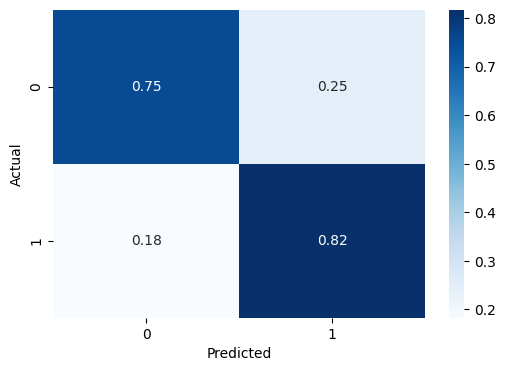

In [37]:
y_val_bagging_tune_pred = bagging_classifier_tune.predict(X_val)
accuracy_tune = accuracy_score(y_val, y_val_bagging_tune_pred)

print(f'Accuracy: {accuracy_tune:.4f}')

print('Classification Report:')
print(classification_report(y_val, y_val_bagging_tune_pred))
bagging_tune_confmat = confusion_matrix(y_val, y_val_bagging_tune_pred, normalize='true')

plt.figure(figsize=(6,4))
sns.heatmap(bagging_tune_confmat,annot=True,cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import joblib
# save the model to disk
filename = './models/svm_grid.sav'
joblib.dump(svm_grid, filename)

loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result)

### **PCA**
Choose the minimum number of principal components such that 95 percent of the variance is retained.

<Figure size 1200x600 with 0 Axes>

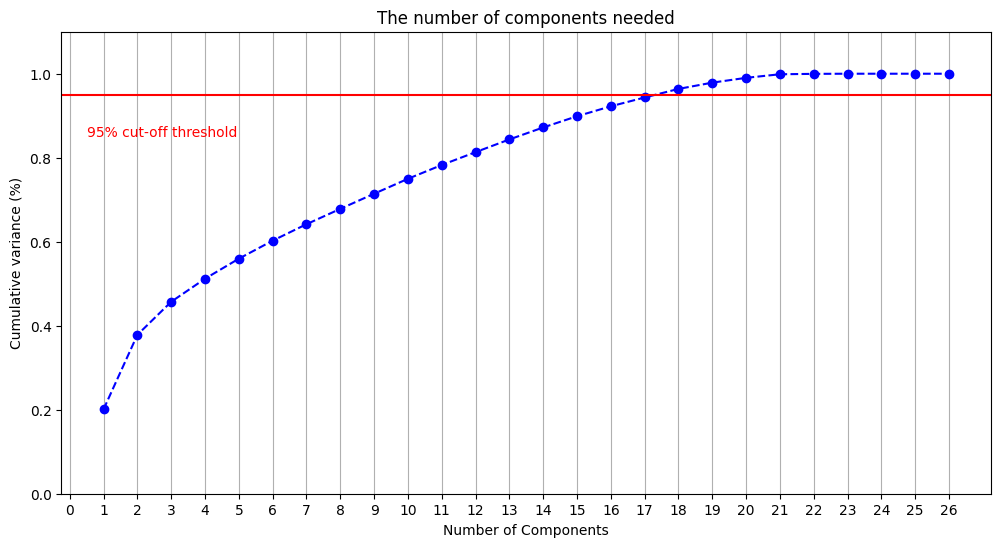

In [35]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA().fit(X_train_normalized)

plt.figure(figsize=(12,6))
fig, ax = plt.subplots()
xi = np.arange(1, 27, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 27, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red')

ax.grid(axis='x')
plt.show()

In [26]:
from sklearn.decomposition import PCA

pca = PCA(.95)
pca.fit(X_train_normalized)
X_train_pca = pca.transform(X_train_normalized)
X_val_pca = pca.transform(X_val_normalized)
X_test_pca = pca.transform(X_test_normalized)

### **Bagging SVM with PCA**

In [27]:
bagging_classifier_pca = BaggingClassifier(base_estimator=svm_classifier, n_estimators=10, random_state=42)

# Measure the training time of the model
t0 = time.time()

bagging_classifier_pca = bagging_classifier_pca.fit(X_train_pca, y_train.values.ravel())

bagging_pca_train_time = time.time()-t0
print(f'Training time: {bagging_pca_train_time:.2f} s')

c:\Users\xiaoc\anaconda3\envs\keras\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training time: 5.81 s


Accuracy: 0.8174
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       493
           1       0.83      0.83      0.83       542

    accuracy                           0.82      1035
   macro avg       0.82      0.82      0.82      1035
weighted avg       0.82      0.82      0.82      1035



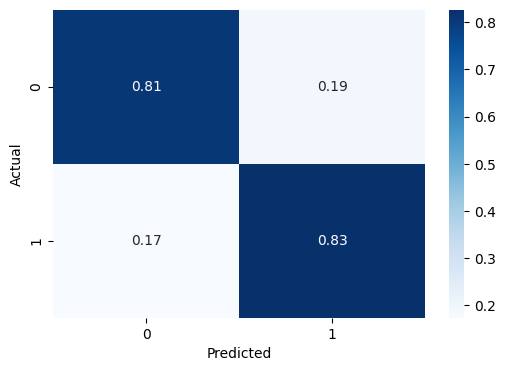

In [36]:
y_val_bagging_pca_pred = bagging_classifier_pca.predict(X_val_pca)
accuracy_pca = accuracy_score(y_val, y_val_bagging_pca_pred)

print(f'Accuracy: {accuracy_pca:.4f}')

print('Classification Report:')
print(classification_report(y_val, y_val_bagging_pca_pred))
bagging_pca_confmat = confusion_matrix(y_val, y_val_bagging_pca_pred, normalize='true')

plt.figure(figsize=(6,4))
sns.heatmap(bagging_pca_confmat,annot=True,cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()